In [1]:
import qiskit
from qiskit import providers,execute,QuantumRegister,ClassicalRegister,QuantumCircuit,transpile,Aer,assemble,IBMQ
from qiskit.tools import job_monitor
from qiskit import *
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from numpy.random import randint,random_integers
from qiskit.providers.aer.noise import NoiseModel
import numpy as np
import math
import random
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error,amplitude_damping_error,phase_damping_error,phase_amplitude_damping_error
from qiskit.providers.aer.noise import thermal_relaxation_error
IBMQ.load_account()
provider=IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider.backends()
aer_sim = Aer.get_backend('aer_simulator')


/tmp/ipykernel_120/1974120072.py:18: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/tmp/ipykernel_120/1974120072.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


In [2]:
def get_noise(p_bit,p_phase,p_gate1,p_gate2):
    bit_flip = pauli_error([('X',p_bit), ('I', 1 - p_bit)])#bit flip
    #phase_flip = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])#phase flip
    #bitphase_flip = phase_flip.compose(phase_flip)
    #error_gate1 = depolarizing_error(p_gate, 1)
    #error_gate2=amplitude_damping_error(p_gate, excited_state_population=0, canonical_kraus=True)
    #error_gate3=phase_damping_error(p_gate, canonical_kraus=True)
    error_gate4=phase_amplitude_damping_error(p_gate1, p_gate2, excited_state_population=0, canonical_kraus=True)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(bit_flip, "measure") # measurement error is applied to measurements
    #noise_model.add_all_qubit_quantum_error(error_gate4, ["x","h"]) # single qubit gate error is applied to x gates
        
    return noise_model

    

In [3]:
def encode_message(bits,bases):
    message=[]
    for i in range(n):
        qc=QuantumCircuit(1,1)
        if(bases[i]==1):#z basis
            if(bits[i]==0):
                pass
            else:
                qc.x(0)
        else:#x basis
            if(bits[i]==0):
                qc.h(0)#creating |+> state 
            else:
                qc.x(0)#converting to 1 
                qc.h(0)#creating |-> state
        message.append(qc)
    return message
  
def measure_message(message,bases): 
    measured=[]
    for j in range(n):
        if(bases[j]==1):# z bases
            message[j].measure(0,0)
        else:# x bases
            message[j].h(0)
            message[j].measure(0,0)
        simul=Aer.get_backend('aer_simulator')
        qobj=assemble(message[j],shots=1,memory=True)
        result=simul.run(qobj,noise_model=noise_model).result()
        measurement=int(result.get_memory()[0])
        measured.append(measurement)
    return measured

def key_selection(s_bases,r_bases,bits):
    good_bits=[]  
    for i in range(n):
        if(s_bases[i]==r_bases[i]):
            good_bits.append(bits[i])
    return good_bits

def sampling(bits,string):
    sample=[]
    for i in string:
        i=np.mod(i,len(bits))#ensuring that the sample string doesnot exceed the key
        sample.append(bits.pop(i))
    return sample


In [4]:
###Ideal Condition without eve in noisy enviornment
from qiskit.circuit import quantumcircuit
#np.random.seed(seed=0)
n=3
sender_bits=np.random.randint(2,size=n)
print("Sender chososes to sent the following string of bits")
print(sender_bits)

#Circuit to test BB84 on ibmq_bogota c

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#Generation of Bits
for i in range(n):
    if(sender_bits[i]==1):
        circuit.x(qreg_q[i])
circuit.draw()

sender_basis=randint(2,size=n)
print("Sender choose the followwing basis where 1 denotes Z basis and 0 denotes X basis")
print(sender_basis)

#Generation of Basis
for i in range(n):
    if(sender_basis[i]==0):
        circuit.h(qreg_q[i])
circuit.draw()



reciever_basis=randint(2,size=n)
print("Reciever choose folowing basis where 1 denotes Z basis and 0 denotes X basis")
print(reciever_basis)
noise_model = get_noise(0.1,0.1,0.1,0.1)  
    
for i in range(n):
    if(reciever_basis[i]==0):
        circuit.h(qreg_q[i])
        circuit.measure(qreg_q[i], creg_c[i])
    else:
        circuit.measure(qreg_q[i], creg_c[i])
circuit.draw()

data=encode_message(sender_bits,sender_basis)
key=measure_message(data,reciever_basis)
s_key=key_selection(sender_basis,reciever_basis,sender_bits)
r_key=key_selection(sender_basis,reciever_basis,key)
print("These are the common key shared")
print(s_key)
print(r_key)

s=math.ceil(len(s_key) * 0.25)
print(" sample .... ", s)
sample_size=randint(0,s)

print("length of sifted key is ",len(s_key) )
print("length of sample taken is ",sample_size)
sample_string = randint(n, size=sample_size)
sender_sample=sampling(s_key,sample_string)
reciever_sample=sampling(r_key,sample_string)

mismatch = 0
for i in range(sample_size):
    if(sender_sample[i]!=reciever_sample[i]):
        mismatch = mismatch+1
print("Sender_Sample")
print(sender_sample)
print("Receiver_Sample")
print(reciever_sample)


if sender_sample==reciever_sample:
    print("Cryptographic_key_is")
    print(s_key)
else:
    print("error or Eve's Dropping")
    error_rate=mismatch/sample_size
    print("Error_rate=",error_rate)
        


Sender chososes to sent the following string of bits
[0 1 0]
Sender choose the followwing basis where 1 denotes Z basis and 0 denotes X basis
[0 0 0]
Reciever choose folowing basis where 1 denotes Z basis and 0 denotes X basis
[1 1 0]
These are the common key shared
[0]
[0]
 sample ....  1
length of sifted key is  1
length of sample taken is  0
Sender_Sample
[]
Receiver_Sample
[]
Cryptographic_key_is
[0]


{'100': 20, '110': 22, '101': 25, '001': 228, '010': 247, '011': 228, '000': 220, '111': 34}


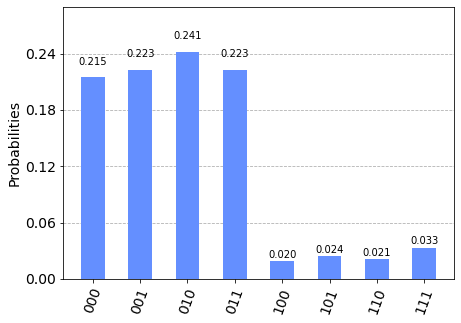

In [5]:
# run the circuit with the noise model and extract the counts
qobj = assemble(circuit)
counts = aer_sim.run(qobj, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

In [6]:
###Non Ideal Condition with eve in noisy enviornment
from qiskit.circuit import quantumcircuit
#np.random.seed(seed=0)
n=3
sender_bits=np.random.randint(2,size=n)
print("Sender chososes to sent the following string of bits")
print(sender_bits)

#Circuit to test BB84 on ibmq_bogota c

qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
circuit_eve = QuantumCircuit(qreg_q, creg_c)

#Generation of Bits
for i in range(n):
    if(sender_bits[i]==1):
        circuit_eve.x(qreg_q[i])
circuit_eve.draw()

sender_basis=randint(2,size=n)
print("Sender choose the followwing basis where 1 denotes Z basis and 0 denotes X basis")
print(sender_basis)

#Generation of Basis
for i in range(n):
    if(sender_basis[i]==0):
        circuit_eve.h(qreg_q[i])
circuit_eve.draw()


attacker_basis=randint(2,size=n)
print("Attacker choose folowing basis with same convention as sender")
print(attacker_basis)

for i in range(n):
    noise_model = get_noise(0.1,0.1,0.1,0.1)  
    if(attacker_basis[i]==0):
        circuit_eve.h(qreg_q[i])
        circuit_eve.measure(qreg_q[i], creg_c[i])
    else:
        circuit_eve.measure(qreg_q[i], creg_c[i])
circuit_eve.draw()


reciever_basis=randint(2,size=n)
print("Reciever choose folowing basis where 1 denotes Z basis and 0 denotes X basis")
print(reciever_basis)
noise_model = get_noise(0.1,0.1,0.1,0.1)  
    
for i in range(n):
    if(reciever_basis[i]==0):
        circuit_eve.h(qreg_q[i])
        circuit_eve.measure(qreg_q[i], creg_c[i])
    else:
        circuit_eve.measure(qreg_q[i], creg_c[i])
circuit_eve.draw()

data=encode_message(sender_bits,sender_basis)
intercepted_message = measure_message(data,attacker_basis)
key=measure_message(data,reciever_basis)
s_key=key_selection(sender_basis,reciever_basis,sender_bits)
r_key=key_selection(sender_basis,reciever_basis,key)
print("These are the common key shared")
print(s_key)
print(r_key)

s=math.ceil(len(s_key) * 0.5)
print(" sample .... ", s)
sample_size=randint(0,s)

print("length of sifted key is ",len(s_key) )
print("length of sample taken is ",sample_size)
sample_string = randint(n, size=sample_size)

sender_sample=sampling(s_key,sample_string)
reciever_sample=sampling(r_key,sample_string)

mismatch = 0
for i in range(sample_size):
    if(sender_sample[i]!=reciever_sample[i]):
        mismatch = mismatch+1

print("Sender_Sample")
print(sender_sample)
print("Receiver_Sample")
print(reciever_sample)

if sender_sample==reciever_sample:
    print("Cryptographic_key_is")
    print(secure_key)
else:
    print("error or Eve's Dropping")
    error_rate=mismatch/sample_size
    print("Error_rate=",error_rate)
        


Sender chososes to sent the following string of bits
[1 0 1]
Sender choose the followwing basis where 1 denotes Z basis and 0 denotes X basis
[0 1 0]
Attacker choose folowing basis with same convention as sender
[1 1 1]
Reciever choose folowing basis where 1 denotes Z basis and 0 denotes X basis
[0 1 0]
These are the common key shared
[1, 0, 1]
[0, 1, 0]
 sample ....  2
length of sifted key is  3
length of sample taken is  0
Sender_Sample
[]
Receiver_Sample
[]
Cryptographic_key_is
Traceback (most recent call last):
  Input In [6] in <cell line: 89>
    print(secure_key)
NameError: name 'secure_key' is not defined

Use %tb to get the full traceback.


{'010': 43, '110': 44, '100': 216, '111': 44, '000': 237, '011': 38, '001': 201, '101': 201}


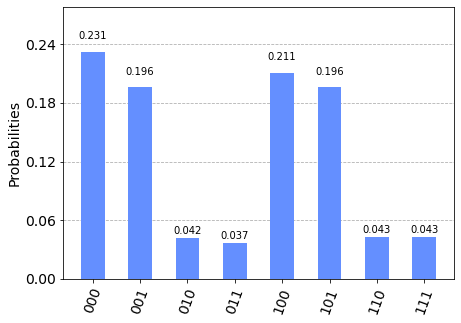

In [7]:
# run the circuit with the noise model and extract the counts
qobj = assemble(circuit_eve)
counts = aer_sim.run(qobj, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)